In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [10]:
df = pd.read_csv(r'C:\Users\Chang.LAPTOP-KLP71L1N\Documents\AIE NLP Practical Course\Project6 Text Classification with CNN\spam.csv', encoding='ISO-8859-1')

In [11]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preprocessing

In [12]:
# drop garbage columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [13]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# rename columns
df.columns = ['labels', 'data']

In [15]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# create binary labels (0 and 1)
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1}) # create new column as 'b_labels'
y = df['b_labels'].values

In [17]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33)

In [18]:
# Initialize a tokenizer with a maximum vocabulary size of 20,000 words
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)

# Fit the tokenizer on the training data to build the vocabulary
tokenizer.fit_on_texts(x_train) 

# Convert the training text data into sequences of integers using the tokenizer
sequences_train = tokenizer.texts_to_sequences(x_train)

# Convert the test text data into sequences of integers using the tokenizer
sequences_test = tokenizer.texts_to_sequences(x_test)

In [19]:
# Check word index mapping (to check the number of words in vocabulary):
word2idx = tokenizer.word_index # Extract the word-to-index mapping from the tokenizer
V = len(word2idx) # Compute the total number of unique tokens in the vocabulary
print('Total number of unique tokens are: %s' % V)

Total number of unique tokens are: 7185


In [20]:
# N: number of samples and T: Number of time steps

data_train = pad_sequences(sequences_train) # pad sequences (to get  N x T matrix)
print('Shape of data train tensor:', data_train.shape)

Shape of data train tensor: (3733, 189)


In [21]:
T = data_train.shape[1] # Assign the sequence length of the data_train dataset to the variable T
print(T)

189


In [22]:
data_test = pad_sequences(sequences_test, maxlen=T) # Pad or truncate sequences in the test set to have a consistent length of T
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


# Building the Model

In [23]:
# Set the dimensionality of word embeddings to 20
D = 20  # this is a hyper parameter, we can choose any word vector size that we want

# Define the size of the hidden state vectors for the LSTM layer
M = 15

# Input layer
i = Input(shape=(T,))  # Define the input layer with input shape of length T

# Embedding layer
x = Embedding(V + 1, D)(i) # Add an embedding layer to transform integer sequences into dense vectors
# This will be an N * T * D array
# we want size of embedding to (V + 1) x D, because first word index starts from 1 and not 0

# LSTM layer
x = LSTM(M, return_sequences=True)(x) # Add an LSTM layer that returns hidden states for each position in the sequence
x = GlobalMaxPooling1D()(x) # Apply global max-pooling to capture the most important feature from the sequence

# Dense layer
x = Dense(1, activation='sigmoid')(x) # Add a dense output layer with a sigmoid activation for binary classification

model = Model(i, x)

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Train the model
r = model.fit(x=data_train, y=y_train, epochs=10, validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 10s 61ms/step - loss: 0.4406 - accuracy: 0.8693 - val_loss: 0.4075 - val_accuracy: 0.8592
Epoch 2/10
117/117 [==============================] - 7s 57ms/step - loss: 0.3836 - accuracy: 0.8693 - val_loss: 0.3942 - val_accuracy: 0.8592
Epoch 3/10
117/117 [==============================] - 7s 57ms/step - loss: 0.3365 - accuracy: 0.8693 - val_loss: 0.2845 - val_accuracy: 0.8592
Epoch 4/10
117/117 [==============================] - 7s 57ms/step - loss: 0.2030 - accuracy: 0.8800 - val_loss: 0.2023 - val_accuracy: 0.9511
Epoch 5/10
117/117 [==============================] - 7s 57ms/step - loss: 0.1308 - accuracy: 0.9778 - val_loss: 0.1606 - val_accuracy: 0.9636
Epoch 6/10
117/117 [==============================] - 7s 58ms/step - loss: 0.0820 - accuracy: 0.9909 - val_loss: 0.1305 - val_accuracy: 0.9685
Epoch 7/10
117/117 [==============================] - 7s 57ms/step - loss: 0.0528 - accuracy: 0.9930 - val_loss: 0.1187 - val_accuracy: 0.966

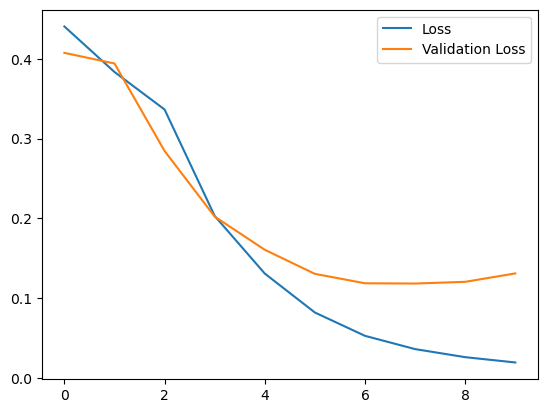

In [28]:
# Loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

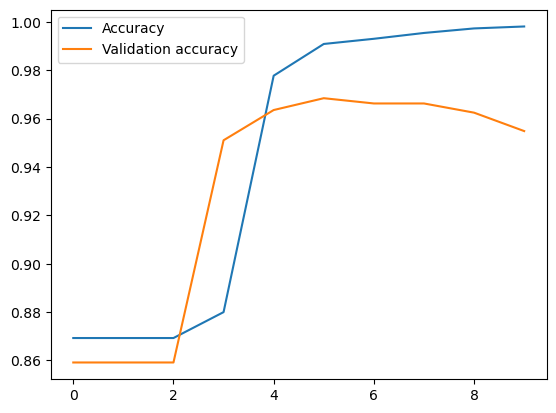

In [29]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()